In [ ]:
from sklearn.preprocessing import StandardScaler


import pandas as pd
df = pd.read_csv("M2_2.18mM_pressure_o2_release.csv")
df_numeric = df.drop(columns=["Sample", "Time (s)", "% Conversion", "DWT denoised pressure (kPa)", ])
#print(df_numeric.head())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)
#print(X_scaled[:5]) the last 2 columns will have 0 variance since they are constant values per column






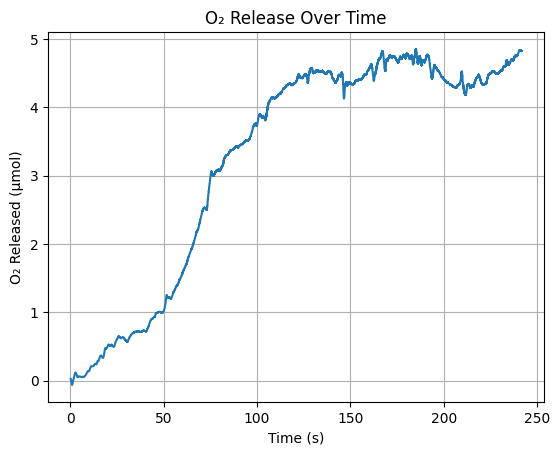

In [21]:
plt.plot(df['Time (s)'], df['O2 Released (µmol)'])
plt.xlabel('Time (s)')
plt.ylabel('O₂ Released (µmol)')
plt.title('O₂ Release Over Time')
plt.grid(True)
plt.show()


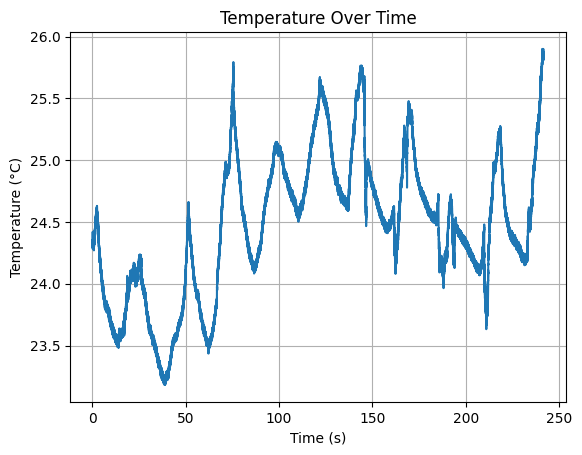

In [23]:
plt.plot(df['Time (s)'], df['calibrated temperature (C)'])
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.grid(True)
plt.show()


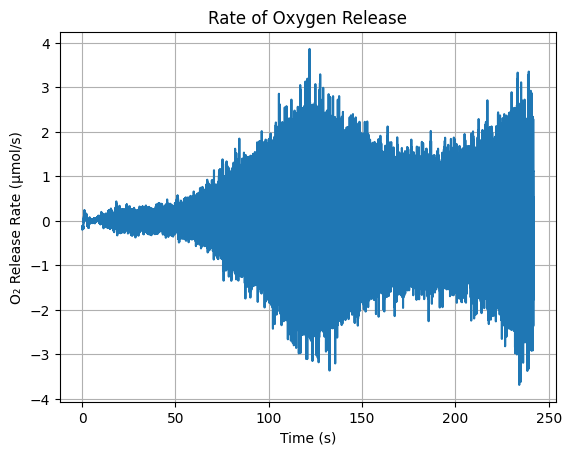

In [27]:
df['dO2_dt'] = df['O2 Released (µmol)'].diff() / df['Time (s)'].diff()

plt.plot(df['Time (s)'], df['dO2_dt'])
plt.xlabel('Time (s)')
plt.ylabel('O₂ Release Rate (µmol/s)')
plt.title('Rate of Oxygen Release')
plt.grid(True)
plt.show()


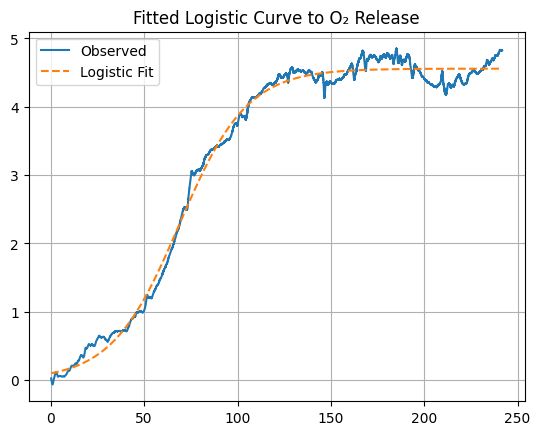

In [29]:
from scipy.optimize import curve_fit

# Logistic function
def logistic(t, a, b, c):
    return c / (1 + np.exp(-a * (t - b)))

popt, _ = curve_fit(logistic, df['Time (s)'], df['O2 Released (µmol)'], p0=[1, 100, 10])

# Plot fit
plt.plot(df['Time (s)'], df['O2 Released (µmol)'], label='Observed')
plt.plot(df['Time (s)'], logistic(df['Time (s)'], *popt), '--', label='Logistic Fit')
plt.legend()
plt.title("Fitted Logistic Curve to O₂ Release")
plt.grid(True)
plt.show()


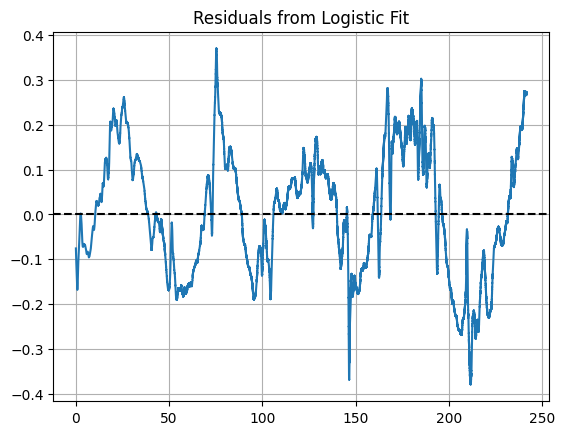

In [31]:
df['expected_O2'] = logistic(df['Time (s)'], *popt)
df['residual'] = df['O2 Released (µmol)'] - df['expected_O2']

plt.plot(df['Time (s)'], df['residual'])
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals from Logistic Fit')
plt.grid(True)
plt.show()


In [40]:
#PCA step

from sklearn.decomposition import PCA


pca = PCA()
X_pca = pca.fit_transform(X_scaled)
#print(X_pca[:5])  # Display the first 5 rows of the PCA transformed data

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_




In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :5], annot=True, cmap='coolwarm', center=0)
plt.title("Feature Loadings for First 5 Principal Components")
plt.show()


In [9]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(X_scaled.shape[1])],
    index=df_numeric.columns
)

# Top contributing features to PC1 and PC2
print(loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False))


                                  PC1       PC2
DWT denoised pressure (kPa)  0.603607 -0.366465
O2 Released (µmol)           0.603189 -0.370854
calibrated temperature (C)   0.521365  0.853329
Soln/Headspace Ratio        -0.000000 -0.000000
Max O2 Possible (µmol)      -0.000000 -0.000000


In [47]:
!pip install statsforecast[complete]


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:

df = pd.read_csv("M2_2.18mM_pressure_o2_release.csv")

In [ ]:
#sampling 3,600 times per second, This is exactly 1/3600 seconds = 1 millisecond


def diagnose_time_frequency(df):

    time_col = df['Time (s)']
    
    print("=== TIME FREQUENCY DIAGNOSIS ===")
    print(f"First 10 time values: {time_col.head(10).tolist()}")
    print(f"Last 10 time values: {time_col.tail(10).tolist()}")
    
    # Check time differences
    time_diffs = time_col.diff().dropna()
    print(f"Time step statistics:")
    print(f"  Mean interval: {time_diffs.mean():} seconds")
    print(f"  Std deviation: {time_diffs.std():} seconds") 
    print(f"  Min interval: {time_diffs.min():} seconds")
    print(f"  Max interval: {time_diffs.max():} seconds")
    
    # Check for regular pattern
    most_common_interval = time_diffs.mode().iloc[0] if len(time_diffs.mode()) > 0 else time_diffs.median()
    print(f"  Most common interval: {most_common_interval:.3f} seconds")
    
    # Check for missing time points
    expected_points = (time_col.max() - time_col.min()) / most_common_interval + 1
    actual_points = len(time_col)
    print(f"  Expected points: {expected_points:.0f}")
    print(f"  Actual points: {actual_points}")
    print(f"  Missing points: {expected_points - actual_points:.0f}")
    
    return most_common_interval

# Run diagnosis
most_common_interval = diagnose_time_frequency(df)

=== TIME FREQUENCY DIAGNOSIS ===
First 10 time values: [0.1669444444444444, 0.1672222228611957, 0.167500001277947, 0.1677777796946984, 0.1680555581114497, 0.168333336528201, 0.1686111149449523, 0.1688888933617037, 0.169166671778455, 0.1694444501952063]
Last 10 time values: [241.6788888831381, 241.67916666155483, 241.6794444399716, 241.67972221838835, 241.6799999968051, 241.68027777522184, 241.6805555536386, 241.68083333205536, 241.6811111104721, 241.68138888888888]
Time step statistics:
  Mean interval: 0.00027777841675133067 seconds
  Std deviation: 1.622887201079609e-14 seconds
  Min interval: 0.00027777841668807923 seconds
  Max interval: 0.0002777784168301878 seconds
  Most common interval: 0.000 seconds
  Expected points: 869451
  Actual points: 869451
  Missing points: 0


In [66]:
def fix_ultra_high_freq_data(df):
 
    # Your time is in fractions of seconds, convert to milliseconds for readability
    df['Time_ms'] = df['Time (s)'] * 1000  # Convert to milliseconds
    
    # Create TimeSeries with millisecond frequency
    ts_o2 = TimeSeries.from_dataframe(
        df,
        time_col='Time_ms',
        value_cols='O2 Released (µmol)',
        freq='0.278ms'  #actual sampling interval
    )

    ts_temp = TimeSeries.from_dataframe(
    df,
    time_col='Time_ms',
    value_cols= 'calibrated temperature (C)',
    freq='0.278ms'  #actual sampling interval
)
    
    return ts_o2, ts_temp


   





In [61]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet, LightGBMModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf

In [ ]:
from darts.utils.statistics import granger_causality_tests

# Does temperature CAUSE O2 release changes?
# Or do O2 changes CAUSE temperature changes?
# Or both?

ts_o2, ts_temp = fix_ultra_high_freq_data(df)

result = granger_causality_tests(
    ts_o2, ts_temp, 
    maxlag=20,  # Test up to 20 time steps of lag
    verbose=False
)

print("Granger causality results:", result)

AttributeError: Invalid type of `time_col`: it needs to be of either 'String', 'Datetime' or 'Int' dtype.


AttributeError: Invalid type of `time_col`: it needs to be of either 'String', 'Datetime' or 'Int' dtype.

In [68]:
# Cross-correlation analysis
from darts.utils.statistics import plot_ccf

# How does temperature change relate to O2 release?
ts_o2, ts_temp = fix_ultra_high_freq_data(df)

plot_ccf(ts_temp, ts_o2, max_lags=50) #try with 100 also
# This shows if temperature changes PREDICT O2 changes (and by how much lag)

AttributeError: Invalid type of `time_col`: it needs to be of either 'String', 'Datetime' or 'Int' dtype.


AttributeError: Invalid type of `time_col`: it needs to be of either 'String', 'Datetime' or 'Int' dtype.

In [ ]:
from darts.ad import QuantileDetector

# Find unusual patterns in your data
detector = QuantileDetector(high_quantile=0.99, low_quantile=0.01)
detector.fit(ts_o2)

anomalies = detector.detect(ts_o2)
# These might indicate measurement errors or interesting chemical events

In [ ]:
from darts.models import Prophet

# Use Facebook's Prophet model (handles trends, seasons, holidays)
prophet_model = Prophet()
prophet_model.fit(ts_o2)

# Predict what would happen if experiment continued
future_prediction = prophet_model.predict(n=1000)  # Next 1000 time points

# Validate against your logistic model predictions!